<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/hw8/Homework/hw8/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 281 (delta 64), reused 58 (delta 53), pack-reused 171
Receiving objects: 100% (281/281), 53.81 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (125/125), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul

In [3]:
from typing import Tuple, List
from tqdm.notebook import trange

import numpy as np
from scipy.stats import norm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions import MultivariateNormal

import matplotlib.pyplot as plt

In [4]:
from dul_2021.utils.hw8_utils import *

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

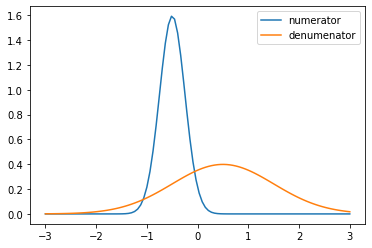

In [6]:
plot_data_q1()

In [7]:
class KernelMeanMatching(nn.Module):
    def __init__(self, dim=1, sigma=1, hd=128):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(dim, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
        self.sigma = sigma

    def get_K(self, x, y):
        #pair_diff_matrix = x.unsqueeze(-1) - y
        #pair_dist_matrix = torch.linalg.norm(pair_diff_matrix, dim=-1) ** 2
        pair_dist_matrix = torch.sum(x ** 2, dim=1, keepdim=True) + torch.sum(y ** 2, dim=1) - 2 * x @ y.T
        return (-0.5 * pair_dist_matrix / self.sigma).exp()
      
    def fit(self, dataloader_nu, dataloader_de, lr=1e-3, epochs=1000):
        optim = opt.Adam(self.r.parameters(), lr=lr)

        for epoch in trange(epochs):
            for (batch_nu, batch_de) in zip(dataloader_nu, dataloader_de):
                batch_size = batch_nu.shape[0]

                batch_nu = batch_nu.float().to(device)
                batch_de = batch_de.float().to(device)
                
                r = self.r(batch_de)
                K_de_de = self.get_K(batch_de, batch_de)
                K_de_nu = self.get_K(batch_de, batch_nu)

                loss = (r.T.matmul(K_de_de).matmul(r) - 2 * r.T.matmul(K_de_nu).sum()) / batch_size ** 2

                optim.zero_grad()
                loss.backward()
                optim.step()
    
    @torch.no_grad()
    def predict(self, batch):
        return self.r(batch).cpu().numpy()

In [8]:
def q1(data_nu, data_de):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution
    
    Returns
      - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """
    batch_size = 512
    lr = 1e-3
    epochs = 1000

    dim = 1
    sigma = 0.1

    dataloader_nu = DataLoader(data_nu.reshape(-1, 1),
                               batch_size=batch_size,
                               shuffle=True)
    dataloader_de = DataLoader(data_de.reshape(-1, 1),
                               batch_size=batch_size,
                               shuffle=True)

    model = KernelMeanMatching(dim, sigma).to(device)

    model.fit(dataloader_nu, dataloader_de, lr, epochs)

    x = np.linspace(-2., 2, num=100)
    x = torch.tensor(x.reshape(-1, 1), dtype=torch.float32, device=device)

    return model.predict(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

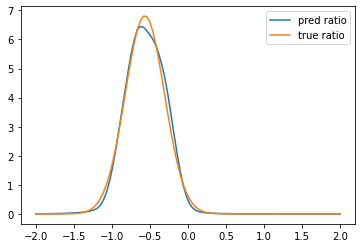

In [30]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [9]:
class Classifier(nn.Module):
    def __init__(self, latent_dim=1, hidden_dim=128):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear_block = nn.Sequential(
            nn.Linear(4 * 4 * 128 + latent_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
  
    def forward(self, x, z):
        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)
        
        return self.linear_block(torch.cat((out, z), dim=1))

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=1, noise_dim=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear_block = nn.Linear(4 * 4 * 128 + noise_dim, latent_dim)

    def forward(self, x, noise):
        batch_size = x.shape[0]

        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)
    
        return self.linear_block(torch.cat((out, noise), dim=1))

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.linear_block = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128),
            nn.ReLU()
        )

        self.conv_transposed_block = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1)
        )
  
    def forward(self, x):
        batch_size = x.shape[0]

        out = self.linear_block(x)

        return self.conv_transposed_block(out.reshape(batch_size, 128, 4, 4))

In [12]:
class AVB(nn.Module):
    def __init__(self, latent_dim=32, noise_dim=32, hidden_dim=128):
        super().__init__()

        self.T = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim)
        self.q = Encoder(latent_dim=latent_dim, noise_dim=noise_dim)
        self.p = Decoder(latent_dim=latent_dim)

        self.latent_dist = MultivariateNormal(
            torch.zeros(latent_dim, device=device),
            torch.eye(latent_dim, device=device)
        )

        self.noize_dist = MultivariateNormal(
            torch.zeros(noise_dim, device=device),
            torch.eye(noise_dim, device=device)
        )
    
    def _calculate_loss(self, batch: torch.tensor):
        batch_size = batch.shape[0]
        
        noise = self.noize_dist.sample((batch_size,))
        z_q = self.q(batch, noise)

        batch_recon = self.p(z_q)
        recon_loss = F.mse_loss(batch, batch_recon, reduction='none')
        recon_loss = recon_loss.reshape(batch_size, -1).sum(dim=1)

        elbo_loss = recon_loss + self.T(batch, z_q)

        with torch.no_grad():
            noise = self.noize_dist.sample((batch_size,))
            z_q = self.q(batch, noise)
        z_sampled = self.latent_dist.sample((batch_size,))

        T_real = torch.sigmoid(self.T(batch, z_q))
        T_fake = torch.sigmoid(self.T(batch, z_sampled))

        real_loss = F.binary_cross_entropy(T_real, torch.ones_like(T_real))
        fake_loss = F.binary_cross_entropy(T_fake, torch.zeros_like(T_fake))
        classifier_loss = real_loss + fake_loss
        # classifier_loss = -(torch.log(T_real) + torch.log(1 - T_fake))

        return elbo_loss.mean(), classifier_loss.mean()
    
    @torch.no_grad()
    def _test(self, test_dataloader: DataLoader) -> List[float]:
        sum_elbo_loss = 0
        sum_classifier_loss = 0
        n_elements = 0
        for batch in test_dataloader:
            batch_size = batch.shape[0]
            batch = batch.to(device)

            elbo_loss, classifier_loss = self._calculate_loss(batch)
            sum_elbo_loss += batch_size * elbo_loss
            sum_classifier_loss += batch_size * classifier_loss
            n_elements += batch_size

        return [
                sum_elbo_loss.item() / n_elements,
                sum_classifier_loss.item() / n_elements,
                ]

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 20,
            lr: float = 1e-3,
            ) -> Tuple[np.ndarray, np.ndarray]:

        train_losses = []
        test_losses = []

        p_q_opt = opt.Adam(
            list(self.q.parameters()) + list(self.p.parameters()), lr=lr
        )
        classifier_optim = opt.Adam(self.T.parameters(), lr=lr)

        test_losses.append(self._test(test_dataloader))

        for epoch in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch.to(device)

                elbo_loss, classifier_loss = self._calculate_loss(batch)

                p_q_opt.zero_grad()
                elbo_loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                p_q_opt.step()

                classifier_optim.zero_grad()
                classifier_loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                classifier_optim.step()

                train_losses.append([elbo_loss.item(), classifier_loss.item()])
            test_losses.append(self._test(test_dataloader))
          
        return np.array(train_losses), np.array(test_losses)

    @torch.no_grad()
    def _tensor2image(self, tensor):
        tensor = 0.5 * tensor.clip(-1, 1) + 0.5
        images = tensor.cpu().numpy()
        return images

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        z_sampled = self.latent_dist.sample((n,))
        samples = self.p(z_sampled) 
        return self._tensor2image(samples)

In [13]:
class AVBDataset(Dataset):
    def __init__(self, images):
        super().__init__()

        self.images = torch.tensor(
            images.transpose(0, 3, 1, 2),
            dtype=torch.float32
        )
        self.images = 2 * self.images - 1

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, index):
        return self.images[index]

In [18]:
def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    batch_size = 256
    epochs = 20
    lr = 1e-3

    latent_dim = 64
    noise_dim = 5
    hidden_dim = 128
    
    train_dataloader = DataLoader(
        AVBDataset(train_data), batch_size=batch_size, shuffle=True
    )
    test_dataloader = DataLoader(
        AVBDataset(test_data), batch_size=batch_size, shuffle=True
    )
    
    model = AVB(latent_dim, noise_dim, hidden_dim).to(device)

    train_losses, test_losses = model.fit(train_dataloader, test_dataloader, epochs, lr)

    return train_losses[:, 0], train_losses[:, 1], test_losses[:, 0], test_losses[:, 1], model.sample(100)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

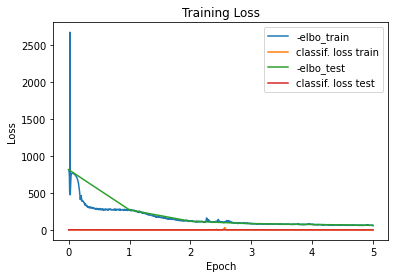

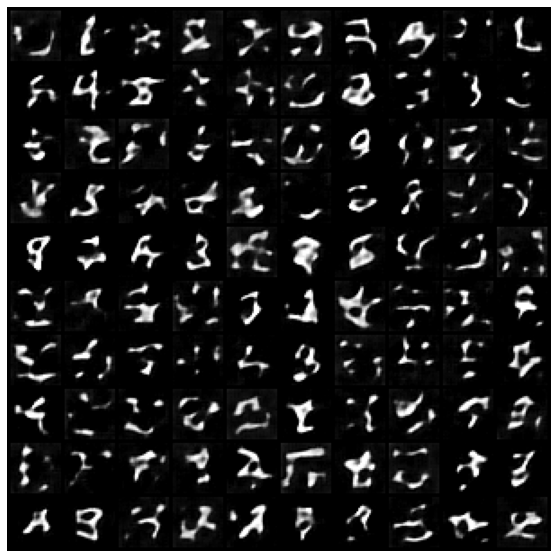

In [17]:
q2_results(q2)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

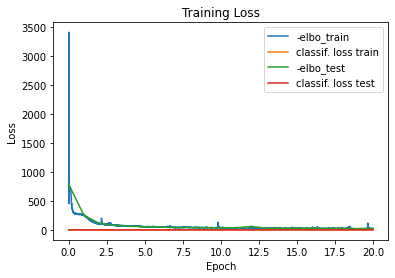

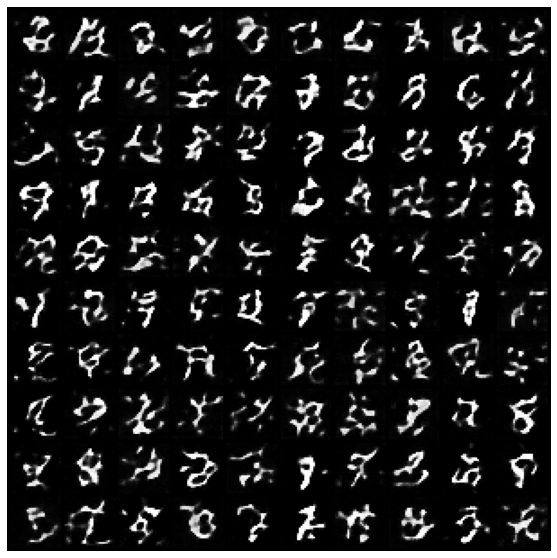

In [19]:
q2_results(q2)

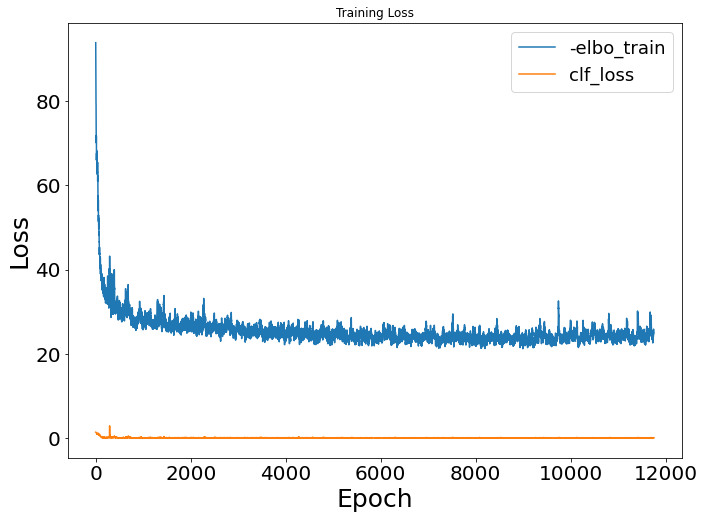

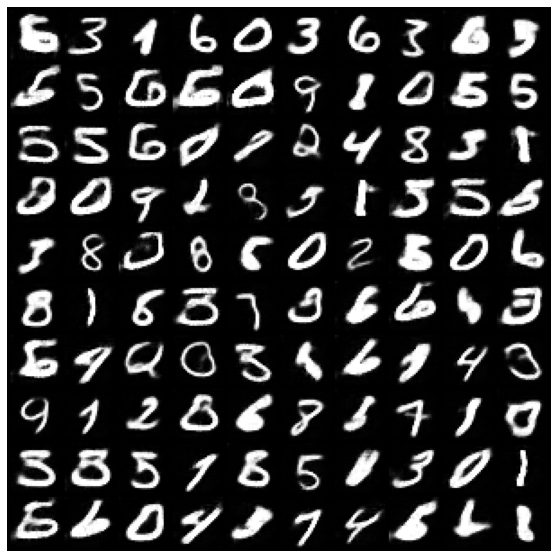

In [ ]:
 q2_results(q2)